In [25]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

^C
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.6 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.6 kB 131.3 kB/s eta 0:00:01
     ------------ ------------------------- 20.5/60.6 kB 131.3 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.6 kB 119.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.6 kB 119.1 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.6 kB 122.9 kB/s eta 0:00:01
     --------------

In [36]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sb
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [37]:
df = pd.read_csv('./data/weather/flight_data.csv')

In [38]:
df.head()

,Flight_ID,Date,Time,Departure_Airport,Arrival_Airport,Temperature_Celsius,Wind_Speed_knots,Turbulence_Level,Visibility_km
0,142,2024-10-11,10:25,ATL Airport,SEA Airport,35,45,High,19
1,110,2024-01-20,18:38,IAH Airport,AUS Airport,3,25,Low,6
2,113,2024-12-26,12:50,STL Airport,SEA Airport,20,48,Medium,6
3,3,2024-08-19,07:28,MCO Airport,LAS Airport,33,48,High,18
4,22,2024-12-07,07:10,LAX Airport,SEA Airport,28,34,Low,20


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Flight_ID            10000 non-null  int64 
 1   Date                 10000 non-null  object
 2   Time                 10000 non-null  object
 3   Departure_Airport    10000 non-null  object
 4   Arrival_Airport      10000 non-null  object
 5   Temperature_Celsius  10000 non-null  int64 
 6   Wind_Speed_knots     10000 non-null  int64 
 7   Turbulence_Level     10000 non-null  object
 8   Visibility_km        10000 non-null  object
dtypes: int64(3), object(6)
memory usage: 703.3+ KB


In [40]:
df.shape

(10000, 9)

In [41]:
df.describe()

,Flight_ID,Temperature_Celsius,Wind_Speed_knots
count,10000.000000,10000.000000,10000.000000
mean,100.685700,10.314800,24.906100
std,57.392387,17.594467,14.812286
min,1.000000,-20.000000,0.000000
25%,50.000000,-5.000000,12.000000
50%,102.000000,11.000000,25.000000
75%,150.000000,25.000000,38.000000
max,200.000000,40.000000,50.000000


In [42]:
df.isnull().sum()

Flight_ID              0
Date                   0
Time                   0
Departure_Airport      0
Arrival_Airport        0
Temperature_Celsius    0
Wind_Speed_knots       0
Turbulence_Level       0
Visibility_km          0
dtype: int64

In [43]:
df['Visibility_km'] = pd.to_numeric(df['Visibility_km'],errors = 'coerce')

In [46]:
cols = ['Temperature_Celsius', 'Wind_Speed_knots']

for column in cols:
    df[column] = df[column].astype(float)

In [47]:
def data_transform(df):
    df = df.drop(columns = ['Flight_ID'])
    df = df.dropna()
    
    def labeling(value):                      #  Turbulence_Level transform
        if value == "High" :                  #  High -> 2, Medium -> 1, Low -> 0
            return 2
        elif value == "Medium" :
            return 1
        else:
            return 0
        
        return None
    
    df['Level'] = df['Turbulence_Level'].apply(labeling)
    df = df.astype({'Level':'int64'})
    
    return df

train = data_transform(df.copy())
train.head()

,Date,Time,Departure_Airport,Arrival_Airport,Temperature_Celsius,Wind_Speed_knots,Turbulence_Level,Visibility_km,Level
0,2024-10-11,10:25,ATL Airport,SEA Airport,35.0,45.0,High,19.0,2
1,2024-01-20,18:38,IAH Airport,AUS Airport,3.0,25.0,Low,6.0,0
2,2024-12-26,12:50,STL Airport,SEA Airport,20.0,48.0,Medium,6.0,1
3,2024-08-19,07:28,MCO Airport,LAS Airport,33.0,48.0,High,18.0,2
4,2024-12-07,07:10,LAX Airport,SEA Airport,28.0,34.0,Low,20.0,0


In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 9999 non-null   object 
 1   Time                 9999 non-null   object 
 2   Departure_Airport    9999 non-null   object 
 3   Arrival_Airport      9999 non-null   object 
 4   Temperature_Celsius  9999 non-null   float64
 5   Wind_Speed_knots     9999 non-null   float64
 6   Turbulence_Level     9999 non-null   object 
 7   Visibility_km        9999 non-null   float64
 8   Level                9999 non-null   int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 781.2+ KB


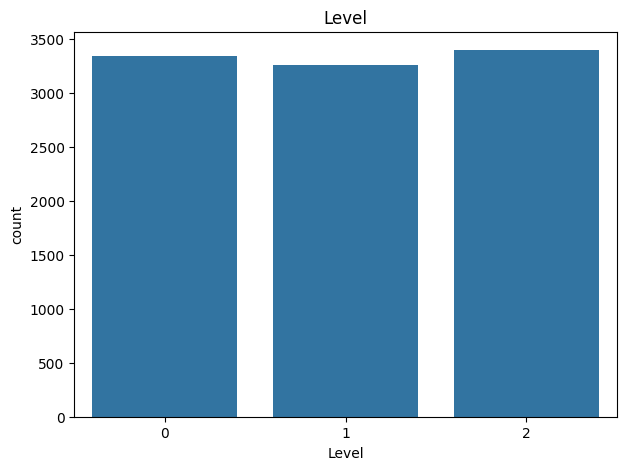

Level
2    3399
0    3342
1    3258
Name: count, dtype: int64

In [13]:
plt.figure(figsize=(7,5))
sb.countplot(data = train , x= 'Level')
plt.title('Level')
plt.show()

train['Level'].value_counts()

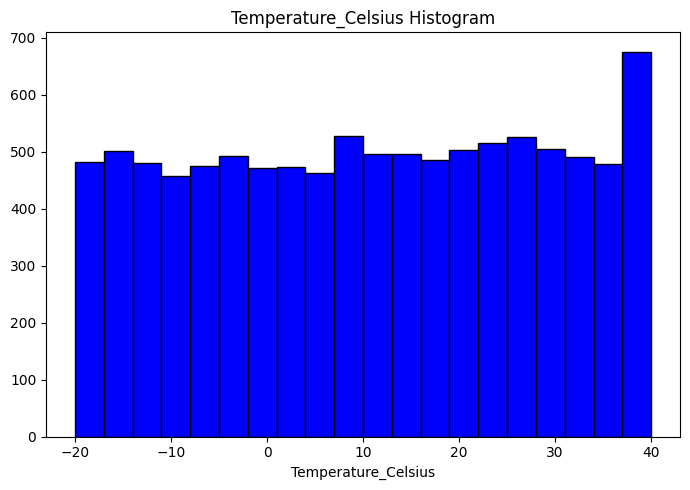

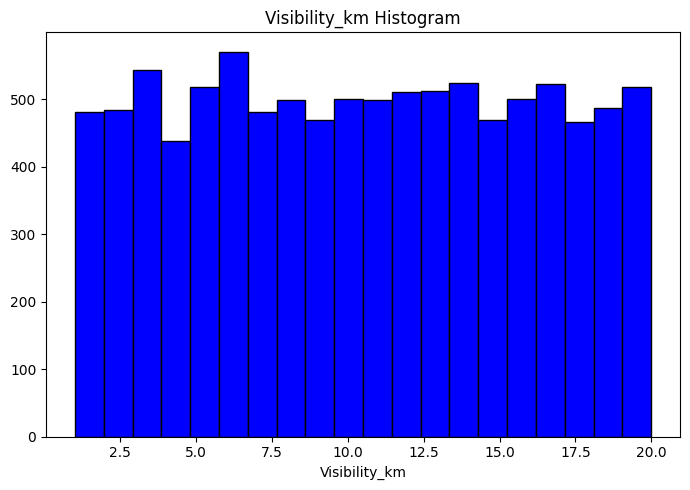

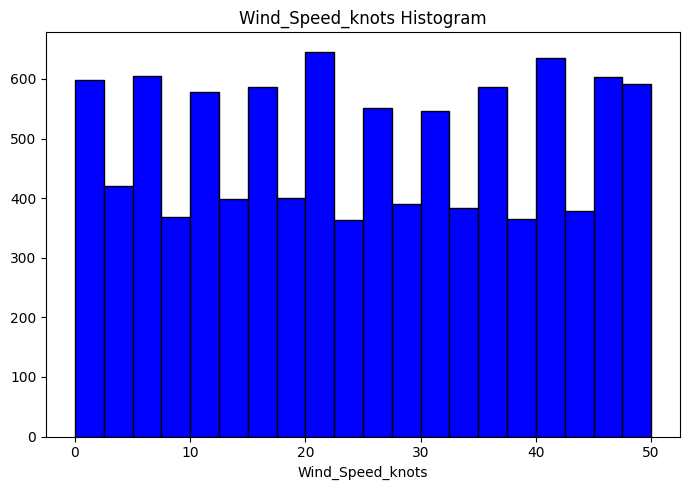

In [14]:
cols = ['Temperature_Celsius' ,'Visibility_km','Wind_Speed_knots']

for i in cols:
    plt.figure(figsize=(7,5))
    plt.hist(train[i], bins=20, color='blue', edgecolor='black')
    plt.xlabel(f'{i}')
    plt.title(f'{i} Histogram')
    plt.tight_layout()
    plt.show()

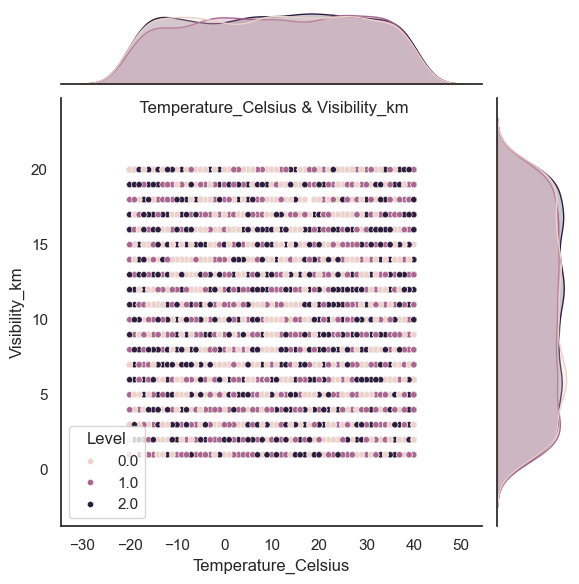

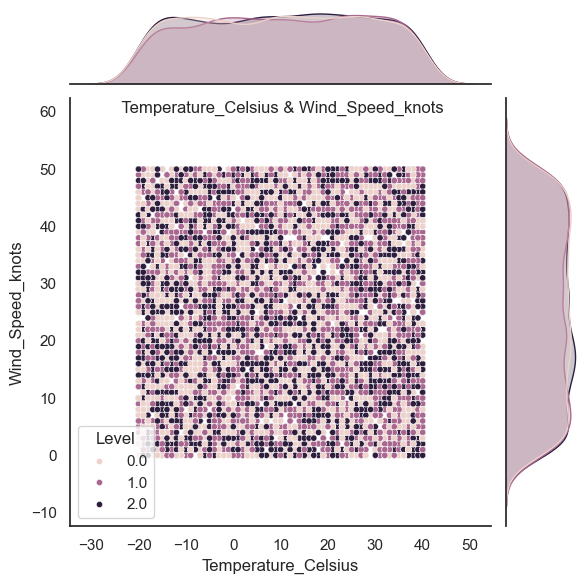

In [15]:
cols = ['Visibility_km','Wind_Speed_knots']

for i in cols:
    sb.set(style="white") 
    sb.jointplot(x='Temperature_Celsius',y= df[i],hue='Level',data=train,s=20)
    plt.title(f' Temperature_Celsius & {i}', pad = -10)
    plt.show()

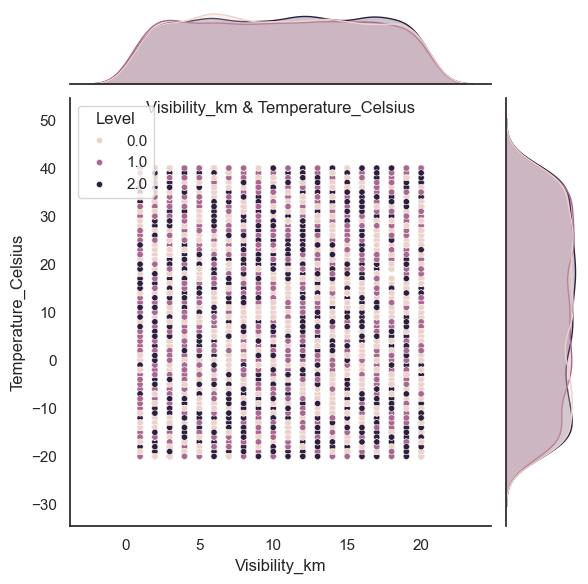

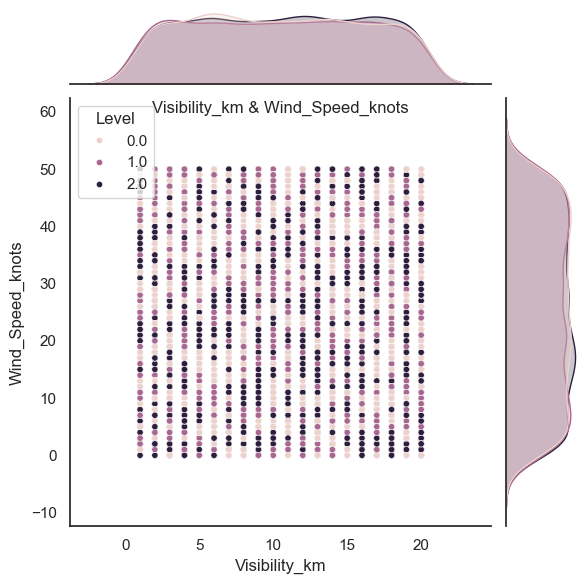

In [16]:
cols = ['Temperature_Celsius' ,'Wind_Speed_knots']

for i in cols:
    sb.set(style="white") 
    sb.jointplot(x='Visibility_km',y= df[i],hue='Level',data=train,s=20)
    plt.title(f'Visibility_km & {i}', pad = -10)
    plt.show()

In [17]:
cols = ['Temperature_Celsius' ,'Visibility_km','Wind_Speed_knots']

train[cols].corr()

,Temperature_Celsius,Visibility_km,Wind_Speed_knots
Temperature_Celsius,1.000000,0.003373,-0.009773
Visibility_km,0.003373,1.000000,-0.015213
Wind_Speed_knots,-0.009773,-0.015213,1.000000


<Axes: >

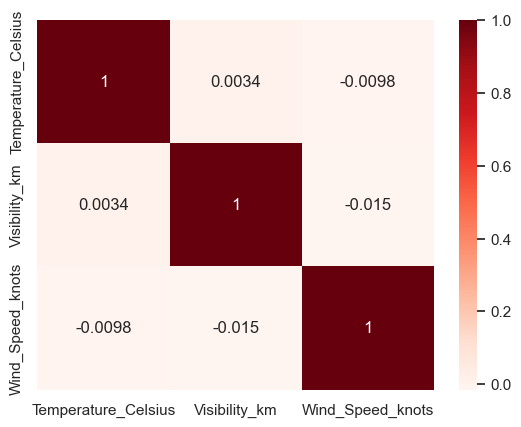

In [18]:
sb.heatmap(train[cols].corr(),annot=True,cmap='Reds')

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

In [20]:
x = train[['Temperature_Celsius' ,'Visibility_km','Wind_Speed_knots']]
y = train['Level']

In [21]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [22]:
x_train

,Temperature_Celsius,Visibility_km,Wind_Speed_knots
9254,-6.0,10.0,48.0
1562,26.0,17.0,12.0
1671,10.0,12.0,28.0
6087,-15.0,12.0,22.0
7333,6.0,1.0,40.0
...,...,...,...
5735,-9.0,1.0,9.0
5192,4.0,15.0,27.0
5391,9.0,20.0,19.0
861,26.0,7.0,46.0


In [23]:
md_lr = LinearRegression()
md_lr.fit(x_train,y_train)

LinearRegression()

In [24]:
pred_lr = md_lr.predict(x_test)

In [25]:
print(f'MAE : {mean_absolute_error(y_test,pred_lr)}')
print(f'MSE : {mean_squared_error(y_test,pred_lr)}')
print(f'RMSE : {np.sqrt(mean_squared_error(y_test,pred_lr))}')
print(f'r2_score : {r2_score(y_test,pred_lr)}')

MAE : 0.6691249055152085
MSE : 0.6651488312599022
RMSE : 0.8155665707101427
r2_score : -0.00044044313340352303


In [26]:
md_rf = RandomForestRegressor(random_state=42)
md_rf.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [27]:
pred_rf = md_rf.predict(x_test)

In [28]:
print(f'MAE : {mean_absolute_error(y_test,pred_rf)}')
print(f'MSE : {mean_squared_error(y_test,pred_rf)}')
print(f'RMSE : {np.sqrt(mean_squared_error(y_test,pred_rf))}')
print(f'r2_score : {r2_score(y_test,pred_rf)}')

MAE : 0.7680768347763347
MSE : 0.8160521186546686
RMSE : 0.9033560309505154
r2_score : -0.22741182850823138


In [29]:
x_train

,Temperature_Celsius,Visibility_km,Wind_Speed_knots
9254,-6.0,10.0,48.0
1562,26.0,17.0,12.0
1671,10.0,12.0,28.0
6087,-15.0,12.0,22.0
7333,6.0,1.0,40.0
...,...,...,...
5735,-9.0,1.0,9.0
5192,4.0,15.0,27.0
5391,9.0,20.0,19.0
861,26.0,7.0,46.0


In [30]:
x_test

,Temperature_Celsius,Visibility_km,Wind_Speed_knots
5345,2.0,3.0,50.0
7445,34.0,3.0,7.0
1732,30.0,2.0,8.0
8720,16.0,2.0,4.0
4522,-14.0,1.0,35.0
...,...,...,...
9449,-13.0,20.0,12.0
8285,26.0,12.0,4.0
7853,1.0,7.0,2.0
1096,38.0,18.0,48.0


In [31]:
y_train

9254    1
1562    0
1671    0
6087    1
7333    1
       ..
5735    2
5192    0
5391    0
861     2
7271    1
Name: Level, Length: 7999, dtype: int64

In [32]:
y_test

5345    2
7445    0
1732    2
8720    2
4522    1
       ..
9449    1
8285    2
7853    1
1096    1
8872    2
Name: Level, Length: 2000, dtype: int64

In [33]:
single_test_case = np.array([[-6.0, 10.0, 48.0]])

In [34]:
predicted_value = md_rf.predict(single_test_case)

In [35]:
print("Predicted value:", predicted_value)


Predicted value: [1.2]
